# Classification with Recurrent Networks
__author__: Pierre Nugues

In this program, we encode the words with unit vectors (one-hot encoding)

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import regex as re

from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader

from torchtext.datasets import IMDB

In [2]:
random.seed(1234)
torch.manual_seed(1234)

In [3]:
MAX_TOKENS = 20000
MAX_LENGTH = 150

EPOCHS = 10
LSTM_HIDDEN_DIM = 32
LSTM_LAYERS = 1
DROPOUT = 0.20

## Dataset

We create iterators for the IMDB dataset. See here for an example: https://pytorch.org/text/stable/datasets.html#text-classification

In [4]:
train_iter, test_iter = IMDB(root='imdb')

In [5]:
train_list_complete = list(train_iter)
test_list = list(test_iter)

In [6]:
len(train_list_complete), len(test_list)

(25000, 25000)

In [7]:
random.shuffle(train_list_complete)

In [8]:
train_list = train_list_complete[:20000]
val_list = train_list_complete[-5000:]

In [9]:
train_list[:3]

[(1,
  "David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into complicated situations, and so does the perspective of the viewer.<br /><br />So is 'Homicide' which from the title tries to set the mind of the viewer to the usual crime drama. The principal characters are two cops, one Jewish and one Irish who deal with a racially charged area. The murder of an old Jewish shop owner who proves to be an ancient veteran of the Israeli Independence war triggers the Jewish identity in the mind and heart of the Jewish detective.<br /><br />This is were the flaws of the film are the more obvious. The process of awakening is theatrical and hard to believe, the group of Jewish militants is operatic, and the way the detective eventually walks to the final violent confrontation is pathetic. The end of the film itself is Mamet-like smart,

We create a tokenizer

In [10]:
def tokenize(text, lc=True):
    if lc:
        return re.findall('\p{L}+', text.lower())
    else:
        return re.findall('\p{L}+', text)

We extract the inputs and outputs and we set the first class to 0 and the second to 1

In [11]:
def extract_io(dataset_list):
    y, corpus = zip(*dataset_list)
    y = [item - 1 for item in y]
    corpus = list(map(tokenize, corpus))
    return y, corpus

In [12]:
y_train, train_corpus = extract_io(train_list)
y_val, val_corpus = extract_io(val_list)
y_test, test_corpus = extract_io(test_list)

In [13]:
len(train_corpus), len(y_train)

(20000, 20000)

In [14]:
len(val_corpus), len(y_val)

(5000, 5000)

In [15]:
len(test_corpus), len(y_test)

(25000, 25000)

In [16]:
train_label_cnt = Counter(y_train)
train_label_cnt

Counter({0: 10024, 1: 9976})

In [17]:
test_label_cnt = Counter(y_test)
test_label_cnt

Counter({0: 12500, 1: 12500})

## Vocabulary

In [18]:
full_text_train = [word for text in train_corpus for word in text]

In [19]:
voc_train_all = list(set(full_text_train))

In [20]:
len(voc_train_all)

67136

In [21]:
cnt_words = Counter(full_text_train)

In [22]:
voc_train = sorted([word for word, _ in cnt_words.most_common(MAX_TOKENS)])

In [23]:
len(voc_train)

20000

We reserve pad and unk

In [24]:
idx2word = {k: v for k, v in enumerate(voc_train, start=2)}
word2idx = {v: k for k, v in idx2word.items()}

In [25]:
X_train_idx = [torch.LongTensor(list(map(lambda x: word2idx.get(x, 1), text[:MAX_LENGTH]))) 
               for text in train_corpus]
X_val_idx = [torch.LongTensor(list(map(lambda x: word2idx.get(x, 1), text[:MAX_LENGTH]))) 
               for text in val_corpus]
X_test_idx = [torch.LongTensor(list(map(lambda x: word2idx.get(x, 1), text[:MAX_LENGTH]))) 
               for text in test_corpus]

In [26]:
X_train_idx[:3]

[tensor([ 4390, 10797,  9388,     2, 19095,  9222,   618,     2, 19095, 18583,
          5951,  4936,  8387,  6717, 11683,  8573, 12311,  7238, 19385, 17865,
         12386,  8691, 10331,  1623,   618,  9417, 15783,     2, 15759, 12311,
          6663, 19704,  2850, 19596, 13059, 12311, 10303,  2829,   940, 17911,
          7391,  9276,  3517, 16195,   618, 16448,  5160, 17865, 13059, 12311,
         17865, 19139,  2055,  2055, 16448,  9388,  8467, 19549,  7116, 17865,
         18078, 18401, 18089, 15783, 17865, 11336, 12311, 17865, 19139, 18089,
         17865, 18950,  4069,  5300, 17865, 13693,  2850,   846, 18537,  3842,
         12386,  9555,   618, 12386,  9363, 19579,  4416, 19704,     2, 14101,
          2853,   847, 17865, 11738, 12311,   591, 12357,  9555, 15988, 12636,
         19579, 13883, 18089,  1441,   591,   617, 19099, 12311, 17865,  9411,
          8956, 19347, 18404, 17865,  9555,  8720,  8890, 17865, 11336,   618,
          8173, 12311, 17865,  9555,  4758,  2055,  

In [27]:
from torch.nn.utils.rnn import pad_sequence
X_train_idx_padded = pad_sequence(X_train_idx, batch_first=True)
X_val_idx_padded = pad_sequence(X_val_idx, batch_first=True)
X_test_idx_padded = pad_sequence(X_test_idx, batch_first=True)

In [28]:
X_train_idx_padded[:3]

tensor([[ 4390, 10797,  9388,     2, 19095,  9222,   618,     2, 19095, 18583,
          5951,  4936,  8387,  6717, 11683,  8573, 12311,  7238, 19385, 17865,
         12386,  8691, 10331,  1623,   618,  9417, 15783,     2, 15759, 12311,
          6663, 19704,  2850, 19596, 13059, 12311, 10303,  2829,   940, 17911,
          7391,  9276,  3517, 16195,   618, 16448,  5160, 17865, 13059, 12311,
         17865, 19139,  2055,  2055, 16448,  9388,  8467, 19549,  7116, 17865,
         18078, 18401, 18089, 15783, 17865, 11336, 12311, 17865, 19139, 18089,
         17865, 18950,  4069,  5300, 17865, 13693,  2850,   846, 18537,  3842,
         12386,  9555,   618, 12386,  9363, 19579,  4416, 19704,     2, 14101,
          2853,   847, 17865, 11738, 12311,   591, 12357,  9555, 15988, 12636,
         19579, 13883, 18089,  1441,   591,   617, 19099, 12311, 17865,  9411,
          8956, 19347, 18404, 17865,  9555,  8720,  8890, 17865, 11336,   618,
          8173, 12311, 17865,  9555,  4758,  2055,  

In [29]:
X_train = F.one_hot(X_train_idx_padded[:3], num_classes=MAX_TOKENS)

In [30]:
X_train

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0]]])

In [31]:
class Model(nn.Module):

    def __init__(self, lstm_units, nbr_classes, num_layers=1, bidi_lstm=False):
        super().__init__()
        self.dropout = nn.Dropout(DROPOUT)
        self.lstm = nn.LSTM(MAX_TOKENS + 2, lstm_units, num_layers=num_layers, 
                            dropout=DROPOUT, batch_first=True, bidirectional=bidi_lstm)
        if not bidi_lstm:
            self.fc = nn.Linear(lstm_units, nbr_classes)
        else:
            # twice the units if bidirectional 
            self.fc = nn.Linear(2*lstm_units, nbr_classes)

    def forward(self, sentence):
        embeds = F.one_hot(sentence, num_classes=MAX_TOKENS + 2).float()
        lstm_out, (h_n, c_n) = self.lstm(embeds)
        lstm_last = F.relu(h_n[-1])
        lstm_last = self.dropout(lstm_last)
        logits = self.fc(lstm_last)
        return logits

In [32]:
model = Model(LSTM_HIDDEN_DIM, 
              2, 
              num_layers=LSTM_LAYERS, 
              bidi_lstm=False)

/Users/pierre/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [33]:
loss_fn = nn.CrossEntropyLoss()    # cross entropy loss
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

In [34]:
X_train = torch.LongTensor(X_train_idx_padded)
y_train = torch.LongTensor(y_train)

X_val = torch.LongTensor(X_val_idx_padded)
y_val = torch.LongTensor(y_val)

X_test = torch.LongTensor(X_test_idx_padded)
y_test = torch.LongTensor(y_test)

In [35]:
X_train[0].size()

torch.Size([150])

In [36]:
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [37]:
y_train.size()

torch.Size([20000])

In [38]:
def batch_inference(model, X, batchsize=2048):
    with torch.no_grad():
        partial = []
        for i in range(0, X.shape[0], batchsize):
            partial.append(model(X[i:i+batchsize]))
    
    return torch.vstack(partial)

In [39]:
X_train[:1]

tensor([[ 4390, 10797,  9388,     2, 19095,  9222,   618,     2, 19095, 18583,
          5951,  4936,  8387,  6717, 11683,  8573, 12311,  7238, 19385, 17865,
         12386,  8691, 10331,  1623,   618,  9417, 15783,     2, 15759, 12311,
          6663, 19704,  2850, 19596, 13059, 12311, 10303,  2829,   940, 17911,
          7391,  9276,  3517, 16195,   618, 16448,  5160, 17865, 13059, 12311,
         17865, 19139,  2055,  2055, 16448,  9388,  8467, 19549,  7116, 17865,
         18078, 18401, 18089, 15783, 17865, 11336, 12311, 17865, 19139, 18089,
         17865, 18950,  4069,  5300, 17865, 13693,  2850,   846, 18537,  3842,
         12386,  9555,   618, 12386,  9363, 19579,  4416, 19704,     2, 14101,
          2853,   847, 17865, 11738, 12311,   591, 12357,  9555, 15988, 12636,
         19579, 13883, 18089,  1441,   591,   617, 19099, 12311, 17865,  9411,
          8956, 19347, 18404, 17865,  9555,  8720,  8890, 17865, 11336,   618,
          8173, 12311, 17865,  9555,  4758,  2055,  

In [40]:
model(X_train[:2])

tensor([[-0.0607,  0.1111],
        [-0.0424,  0.0934]], grad_fn=<AddmmBackward0>)

In [41]:
#y_train_pred = batch_inference(model, X_train)

In [42]:
history = {}
history['accuracy'] = []
history['loss'] = []
history['val_accuracy'] = []
history['val_loss'] = []

In [43]:
# Write your code
for epoch in range(EPOCHS):
    train_loss = 0
    train_accuracy = 0
    val_loss = 0
    val_accuracy = 0
    word_cnt = 0
    batch_cnt = 0
    model.train()
    for X_batch, y_batch in tqdm(dataloader):
        batch_cnt += 1
        Y_batch_pred = model(X_batch)
        loss = loss_fn(Y_batch_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    with torch.no_grad():
        train_accuracy = torch.sum(torch.argmax(batch_inference(model, X_train), dim=-1) == y_train)
        history['accuracy'] += [train_accuracy.item()/y_train.size()[0]]
        history['loss'] += [train_loss/batch_cnt]
        
        y_val_pred = batch_inference(model, X_val)
        val_loss = loss_fn(y_val_pred, y_val)
        history['val_loss'] += [val_loss.item()]
        val_accuracy = torch.sum(torch.argmax(batch_inference(model, X_val), dim=-1) == y_val)
        history['val_accuracy'] += [val_accuracy.item()/y_val.size()[0]]

100%|██████████| 625/625 [07:21<00:00,  1.42it/s]


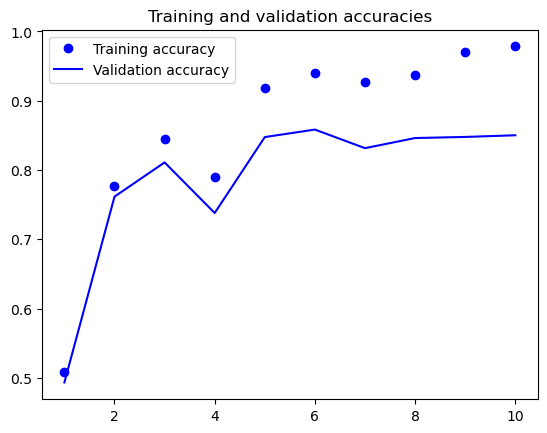

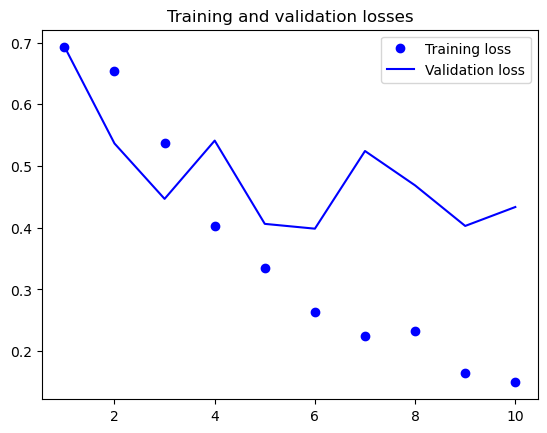

In [44]:
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracies')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation losses')
plt.legend()

plt.show()

In [45]:
history

{'accuracy': [0.5079,
  0.7776,
  0.84545,
  0.79025,
  0.91855,
  0.94,
  0.92675,
  0.93725,
  0.97085,
  0.97835],
 'loss': [0.6924437975883484,
  0.6538786486148834,
  0.5368447896957398,
  0.40215419313907624,
  0.3338583187222481,
  0.26387647536993025,
  0.2240818671286106,
  0.23216692180335521,
  0.16407340989261865,
  0.14916251504719258],
 'val_accuracy': [0.4934,
  0.7616,
  0.811,
  0.738,
  0.8476,
  0.8584,
  0.8316,
  0.8462,
  0.8478,
  0.8502],
 'val_loss': [0.6935693621635437,
  0.5364240407943726,
  0.4466504454612732,
  0.5410550832748413,
  0.40615761280059814,
  0.39836224913597107,
  0.5241903066635132,
  0.46849408745765686,
  0.40280255675315857,
  0.4334476590156555]}

In [46]:
torch.save(model.state_dict(), 'classification_one_hot.pth')